In [25]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
import gym 
import os
import copy
from collections import deque

import matplotlib.pyplot as plt

In [147]:
class DQN() :
    
    def __init__(self , envName = "CartPole" ) :
        self.env = gym.make("{}-v0".format(envName))
        self.envName = envName
        self.prefix = "DQN"
        self.modelName = "{}-{}".format(self.prefix,self.envName)
        self.modelPath = "./model/{}-{}.h5".format(self.prefix,self.envName)
        self.memory = deque(maxlen = 3000)
        
        self.gamma = 0.9
        
        #epsilon for egreedy
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self._buildModel()
        self.history = {"score":[]}
        
        #if os.path.exists(self.modelPath) :
        #    self.loadModel(self.modelPath) 
        #    self.epsilon = self.epsilon_min
        #else :
        #    self._buildModel()         
       
    def loadModel(self,path=None) :
        if path==None :
            path = self.modelPath
        assert os.path.exists(path) 
        self.model = tf.keras.models.load_model(path)
        self.epsilon = self.epsilon_min
        print("load model {} in {} success".format(self.modelName , path))
            
    def saveModel(self,path=None) :
        if path==None :
            path = self.modelPath
        self.model.save(path)
        print("save model {} success.".format(self.modelName ))
        
    def _buildModel(self) :
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(64 , input_shape = self.env.observation_space.shape ,activation="relu" ))
        model.add(tf.keras.layers.Dense(128 ,activation="relu" ))
        model.add(tf.keras.layers.Dense(128 ,activation="relu" ))
        model.add(tf.keras.layers.Dense(self.env.action_space.n ,activation="linear" ))
        model.compile(loss="mse", optimizer="adam" )
        model.summary()
        self.model = model
        print("build model {} success".format(self.modelName))
    
    def act(self,state):
        if np.random.random() <= self.epsilon :
            return self.env.action_space.sample()
        else :
            state = state.reshape(-1,self.env.observation_space.shape[0])
            return np.argmax(self.model.predict(state))
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append( (state, action, reward, next_state, done) )
    
    def update_epsilon(self):
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def replay(self , batch_size) :
        batch_size = min(batch_size , len(self.memory))
        batches = np.random.choice(len(self.memory) , batch_size )
        for i in batches :
            state, action, reward, next_state, done = self.memory[i]
            if not done :
                reward += self.gamma * np.amax(self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)
        self.update_epsilon()
    
    def getReward(state, reward, done) :
        return 100 if done else reward
    
    def train(self, epochs , render = False) :
        for epoch in range(epochs+1) :
            state  = self.env.reset()
            state = state.reshape(-1,self.env.observation_space.shape[0])
            done = False
            score = 0
            while not done :
                if render :
                    self.env.render()
                action = agent.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = next_state.reshape(-1,self.env.observation_space.shape[0])
                
                reward = self.getReward(state , reward , done)
                score += reward
                
                agent.remember(state, action, reward, next_state, done)
                
                state = copy.deepcopy(next_state)
                state = state.reshape(-1,self.env.observation_space.shape[0])
                
                if done :
                    self.history["score"].append(score)
                    print("epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                    score=0
            self.replay(32)        
            if epoch%100 == 0 :
                self.saveModel()
        self.env.close()
    
    def play(self , epochs , render = False) :
        state  = self.env.reset()
        epoch = 0
        score = 0
        while epoch<epochs :
            if render :
                self.env.render()
            state = state.reshape(-1,self.env.observation_space.shape[0])
            action = np.argmax(self.model.predict(state))
            next_state , reward , done , _ = self.env.step(action)
            reward = self.getReward(state , reward , done)
            score += reward
            state = copy.deepcopy(next_state)
            
            if done :
                print( "epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                epoch += 1
                state  = self.env.reset()
                score = 0
        self.env.close()

In [162]:
def getReward(state, reward, done) :
    return state[0,0]+10 if  state[0,0]>=0.5 else state[0,0]

agent = DQN("MountainCar")
agent.getReward = getReward
# agent.loadModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 64)                192       
_________________________________________________________________
dense_144 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_145 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_146 (Dense)            (None, 3)                 387       
Total params: 25,411
Trainable params: 25,411
Non-trainable params: 0
_________________________________________________________________
build model DQN-MountainCar success


In [ ]:
agent.train(1000)

epoch 0 / 1000 played -105.02946732745161 scores.
save model DQN-MountainCar success.
epoch 1 / 1000 played -107.069102248589 scores.
epoch 2 / 1000 played -104.44320262891063 scores.
epoch 3 / 1000 played -103.19513899407447 scores.
epoch 4 / 1000 played -104.31614395708164 scores.
epoch 5 / 1000 played -102.27031376927286 scores.
epoch 6 / 1000 played -104.7474423138012 scores.
epoch 7 / 1000 played -102.9693027025973 scores.
epoch 8 / 1000 played -103.34146322647246 scores.
epoch 9 / 1000 played -102.19312929465926 scores.
epoch 10 / 1000 played -107.09719160987359 scores.
epoch 11 / 1000 played -103.70420590122623 scores.
epoch 12 / 1000 played -105.4151088987436 scores.
epoch 13 / 1000 played -102.78102775904019 scores.
epoch 14 / 1000 played -105.77741301958568 scores.
epoch 15 / 1000 played -101.58763935237826 scores.
epoch 16 / 1000 played -106.13982927548204 scores.
epoch 17 / 1000 played -104.72658734602037 scores.
epoch 18 / 1000 played -103.20171127473455 scores.
epoch 19 /

epoch 160 / 1000 played -104.80777615210376 scores.
epoch 161 / 1000 played -87.83645837197442 scores.
epoch 162 / 1000 played -120.64793898088953 scores.
epoch 163 / 1000 played -117.63865929617818 scores.
epoch 164 / 1000 played -94.45891920481594 scores.
epoch 165 / 1000 played -85.95468176959011 scores.
epoch 166 / 1000 played -118.7276360106636 scores.
epoch 167 / 1000 played -123.20110759793569 scores.
epoch 168 / 1000 played -101.83382079863412 scores.
epoch 169 / 1000 played -87.06663615617212 scores.
epoch 170 / 1000 played -88.89497979259545 scores.
epoch 171 / 1000 played -86.18527739696688 scores.
epoch 172 / 1000 played -86.63775276949787 scores.
epoch 173 / 1000 played -90.03864560178397 scores.
epoch 174 / 1000 played -87.20552968889281 scores.
epoch 175 / 1000 played -106.38046938685086 scores.
epoch 176 / 1000 played -89.0913232723445 scores.
epoch 177 / 1000 played -89.89796610655875 scores.
epoch 178 / 1000 played -87.11754668719725 scores.
epoch 179 / 1000 played -8

In [163]:
agent.play(5,True)

epoch 0 / 10 played -105.84625672937676 scores.
epoch 1 / 10 played -104.34433559833522 scores.
epoch 2 / 10 played -105.90646645760131 scores.
epoch 3 / 10 played -104.44221949836235 scores.
epoch 4 / 10 played -105.75774535551565 scores.
epoch 5 / 10 played -105.46167188062087 scores.
epoch 6 / 10 played -105.4445563466573 scores.
epoch 7 / 10 played -104.83400628306624 scores.
epoch 8 / 10 played -105.93246739679576 scores.
epoch 9 / 10 played -104.80667717984277 scores.


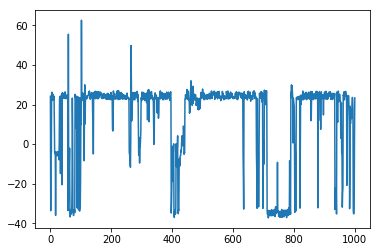

In [159]:
plt.plot(agent.history["score"])